In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from custom_models.ddpm import MyDDPM, MyUNet, FixedUNet
import torch
import torch.nn as nn
from utils import load_medMNIST_data
import torch.nn.functional as F

In [3]:
dataloader, dataset = load_medMNIST_data()

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/
Using downloaded and verified file: C:\Users\josem\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\bloodmnist.npz
Image size: torch.Size([3, 28, 28])
Label size: torch.Size([1])
Label values: {0, 1, 2, 3, 4, 5, 6, 7}


In [4]:
# get image size from the dataset
channels, dim_1, dim_2 = dataloader.dataset[0][0].shape

print(f"Channels: {channels}")
print(f"Dim 1: {dim_1}")
print(f"Dim 2: {dim_2}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Channels: 3
Dim 1: 28
Dim 2: 28


In [5]:
# ********** Training parameters **********
lr = 1e-4  
n_epochs = 100  

# ********** DDPM parameters **********

# Defining model
n_steps, min_beta, max_beta = 300, 10 ** -4, 0.02  # Originally used by the authors of the paper
ddpm = MyDDPM(
    FixedUNet(n_steps=n_steps, in_channels=channels), 
    n_steps=n_steps, 
    min_beta=min_beta, 
    max_beta=max_beta, 
    device=device, 
    image_chw=(channels, dim_1, dim_2)
)

In [6]:

from tqdm import tqdm

from custom_models.ddpm import generate_new_images, show_images


def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        
        for batch in loader:
            x0 = batch[0].to(device)
            n = len(x0)
            
            # Ensure proper tensor shapes
            assert x0.shape[1:] == ddpm.image_chw, f"Shape mismatch: {x0.shape[1:]} vs {ddpm.image_chw}"
            
            eta = torch.randn_like(x0)
            t = torch.randint(0, ddpm.n_steps, (n,)).to(device)
            
            noisy_imgs = ddpm(x0, t, eta)
            eta_theta = ddpm.backward(noisy_imgs, t)
            
            loss = mse(eta, eta_theta)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            epoch_loss += loss.item() * len(x0) / len(loader.dataset)
        
        # Generate samples every few epochs to monitor progress
        if epoch % 10 == 0:
            with torch.no_grad():
                samples = generate_new_images(ddpm, n_samples=4, device=device)
                show_images(samples, f"Epoch {epoch}")
        
        print(f"Epoch {epoch}: Loss = {epoch_loss:.4f}")
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save({
                'model_state_dict': ddpm.state_dict(),
                'n_steps': ddpm.n_steps,
                'image_chw': ddpm.image_chw,
                'epoch': epoch,
                'loss': epoch_loss
            }, store_path)


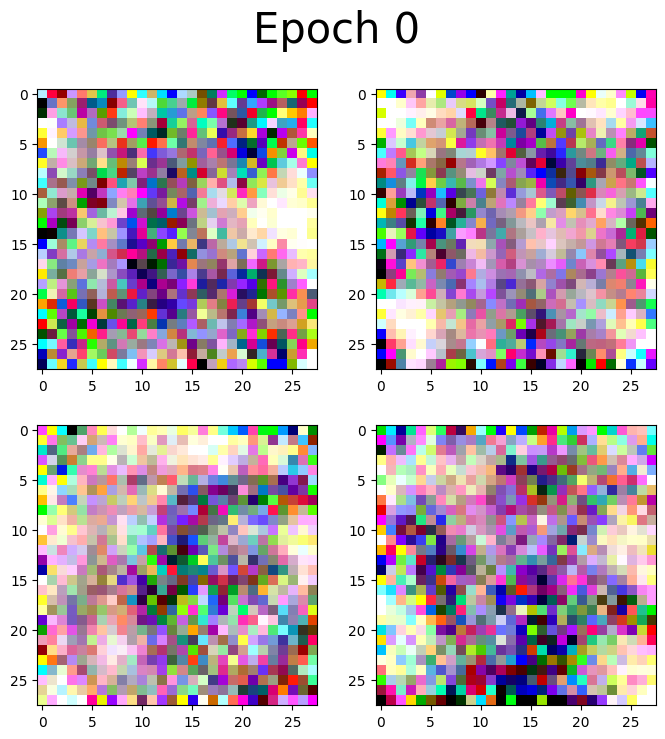

Epoch 0: Loss = 0.5737
Epoch 1: Loss = 0.2380
Epoch 2: Loss = 0.1762
Epoch 3: Loss = 0.1497
Epoch 4: Loss = 0.1353
Epoch 5: Loss = 0.1255
Epoch 6: Loss = 0.1183
Epoch 7: Loss = 0.1089
Epoch 8: Loss = 0.1072
Epoch 9: Loss = 0.1011


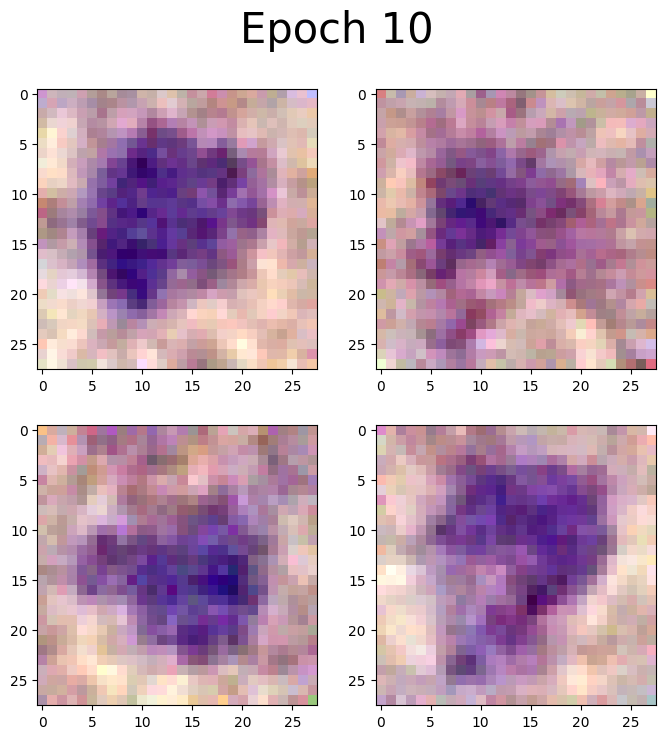

Epoch 10: Loss = 0.0991
Epoch 11: Loss = 0.0942
Epoch 12: Loss = 0.0913
Epoch 13: Loss = 0.0897
Epoch 14: Loss = 0.0889
Epoch 15: Loss = 0.0867
Epoch 16: Loss = 0.0851
Epoch 17: Loss = 0.0847
Epoch 18: Loss = 0.0829
Epoch 19: Loss = 0.0817


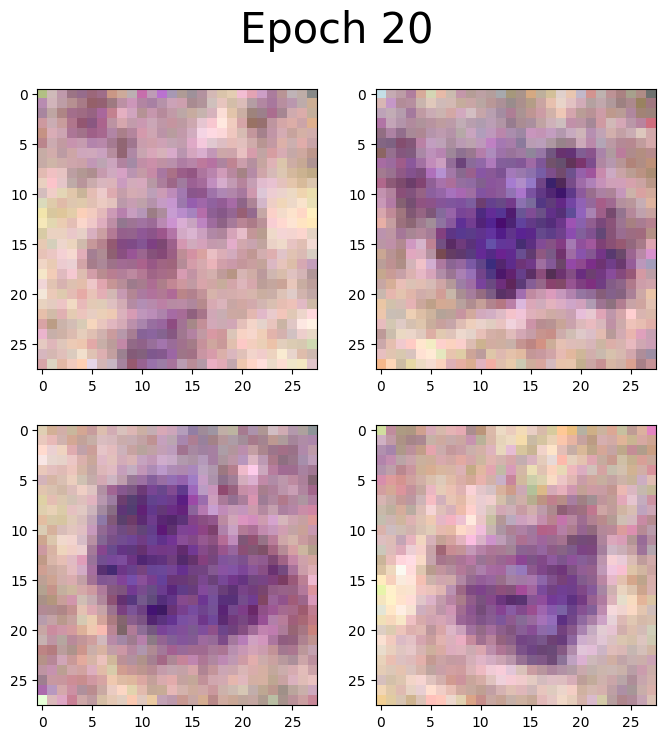

Epoch 20: Loss = 0.0804
Epoch 21: Loss = 0.0796
Epoch 22: Loss = 0.0785
Epoch 23: Loss = 0.0782
Epoch 24: Loss = 0.0764
Epoch 25: Loss = 0.0782
Epoch 26: Loss = 0.0751
Epoch 27: Loss = 0.0747
Epoch 28: Loss = 0.0743
Epoch 29: Loss = 0.0751


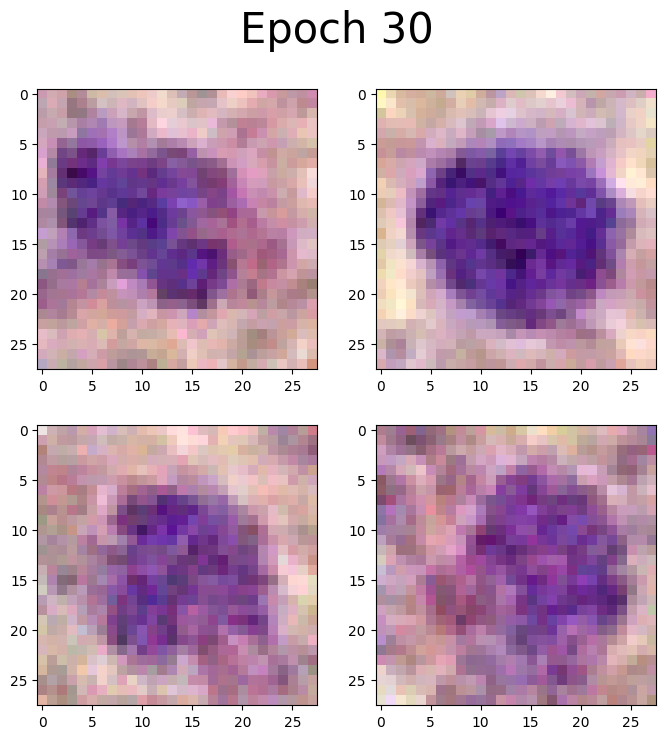

Epoch 30: Loss = 0.0721
Epoch 31: Loss = 0.0738
Epoch 32: Loss = 0.0707
Epoch 33: Loss = 0.0725
Epoch 34: Loss = 0.0702
Epoch 35: Loss = 0.0714
Epoch 36: Loss = 0.0698
Epoch 37: Loss = 0.0691
Epoch 38: Loss = 0.0694
Epoch 39: Loss = 0.0681


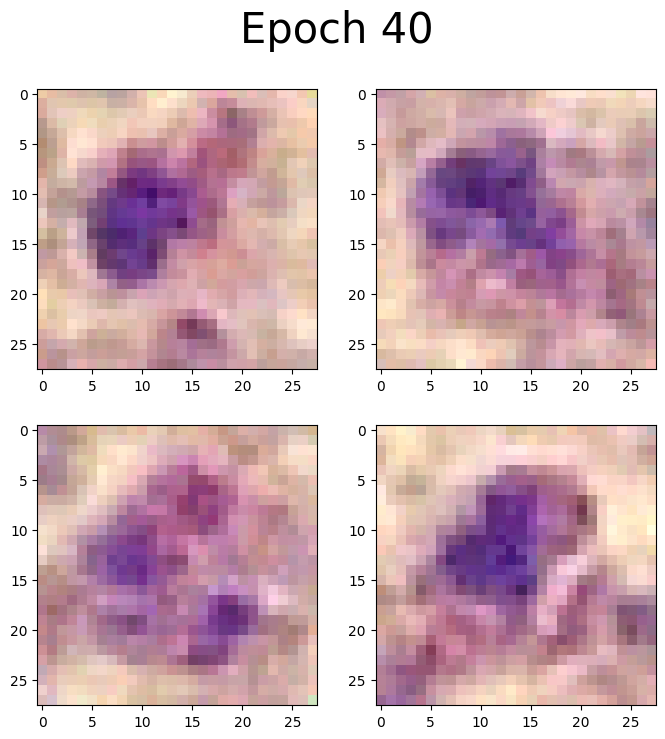

Epoch 40: Loss = 0.0676
Epoch 41: Loss = 0.0681
Epoch 42: Loss = 0.0666
Epoch 43: Loss = 0.0672
Epoch 44: Loss = 0.0666
Epoch 45: Loss = 0.0662
Epoch 46: Loss = 0.0649
Epoch 47: Loss = 0.0651
Epoch 48: Loss = 0.0643
Epoch 49: Loss = 0.0662


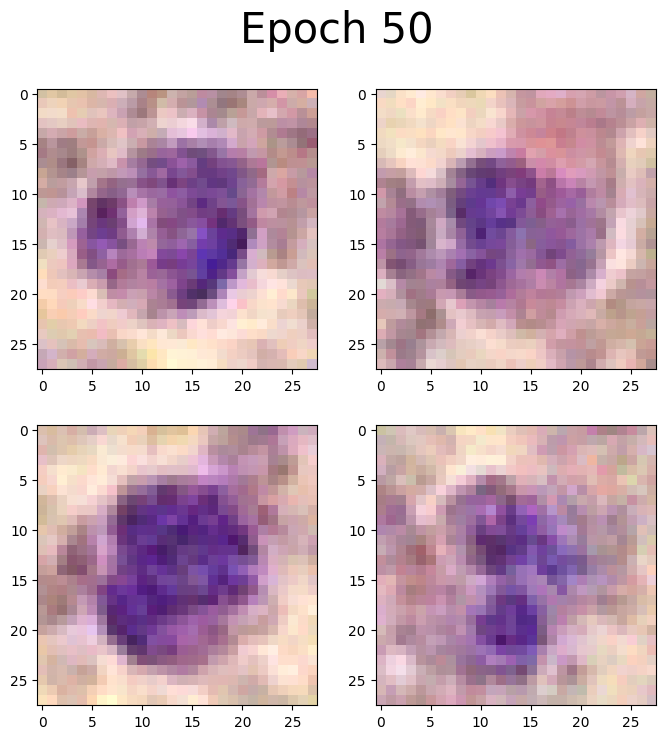

Epoch 50: Loss = 0.0649
Epoch 51: Loss = 0.0636
Epoch 52: Loss = 0.0639
Epoch 53: Loss = 0.0640
Epoch 54: Loss = 0.0627
Epoch 55: Loss = 0.0625
Epoch 56: Loss = 0.0625
Epoch 57: Loss = 0.0627
Epoch 58: Loss = 0.0626
Epoch 59: Loss = 0.0602


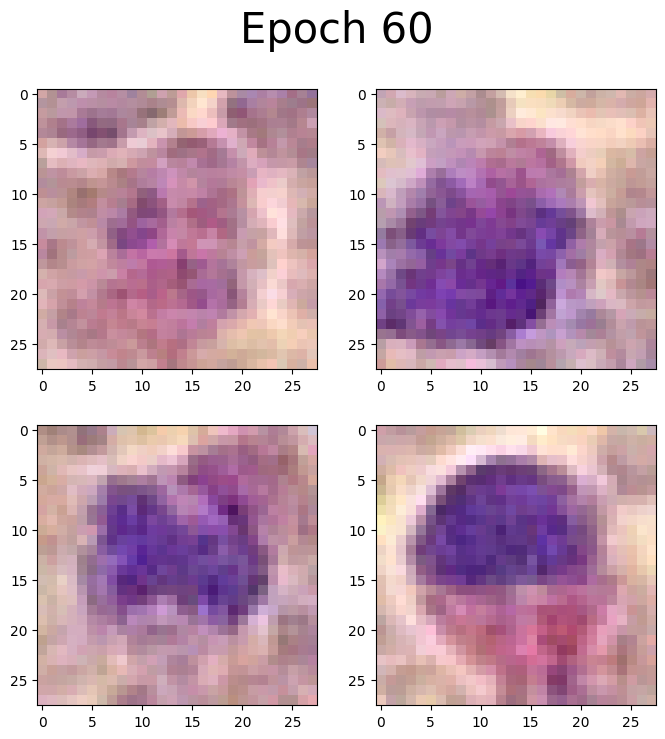

Epoch 60: Loss = 0.0615
Epoch 61: Loss = 0.0616
Epoch 62: Loss = 0.0613
Epoch 63: Loss = 0.0599
Epoch 64: Loss = 0.0621
Epoch 65: Loss = 0.0604
Epoch 66: Loss = 0.0604
Epoch 67: Loss = 0.0598
Epoch 68: Loss = 0.0586
Epoch 69: Loss = 0.0594


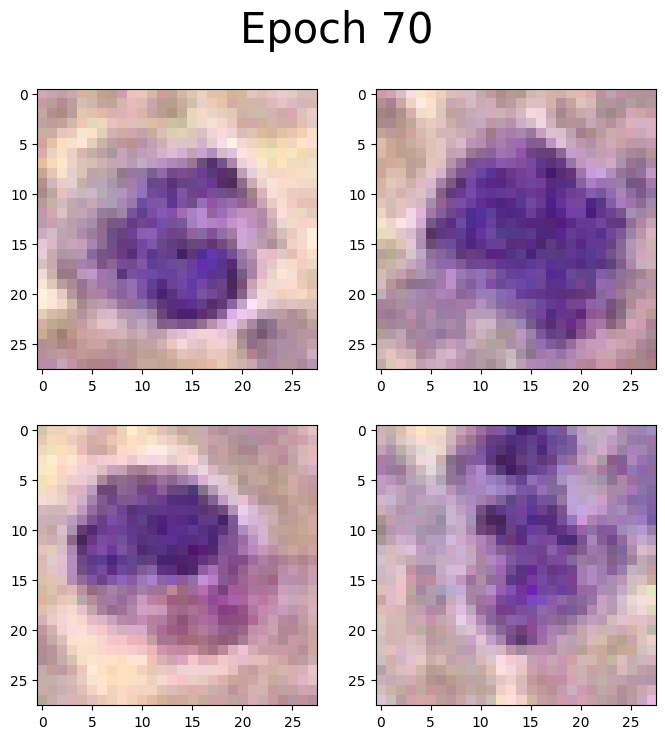

Epoch 70: Loss = 0.0600
Epoch 71: Loss = 0.0591
Epoch 72: Loss = 0.0603
Epoch 73: Loss = 0.0572
Epoch 74: Loss = 0.0576
Epoch 75: Loss = 0.0584
Epoch 76: Loss = 0.0582
Epoch 77: Loss = 0.0577
Epoch 78: Loss = 0.0586
Epoch 79: Loss = 0.0570


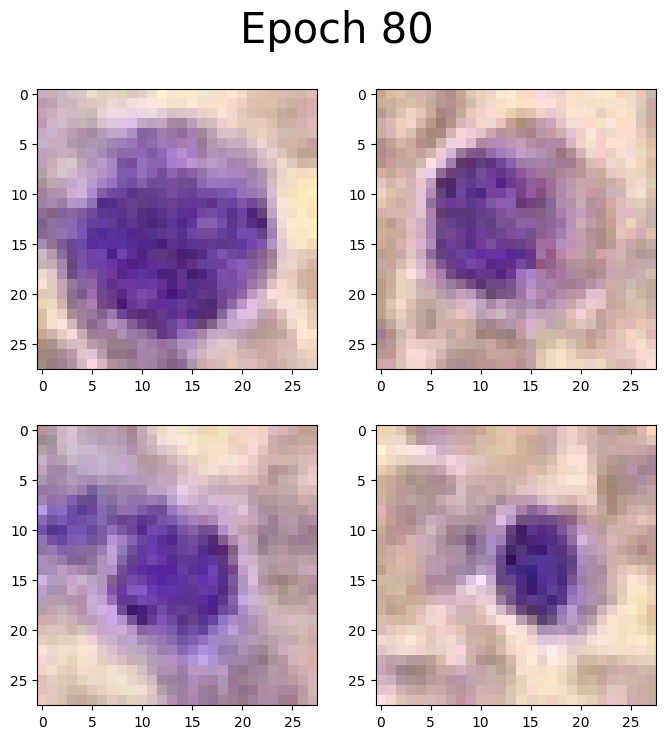

Epoch 80: Loss = 0.0559
Epoch 81: Loss = 0.0568
Epoch 82: Loss = 0.0578
Epoch 83: Loss = 0.0564
Epoch 84: Loss = 0.0564
Epoch 85: Loss = 0.0565
Epoch 86: Loss = 0.0559
Epoch 87: Loss = 0.0574
Epoch 88: Loss = 0.0563
Epoch 89: Loss = 0.0557


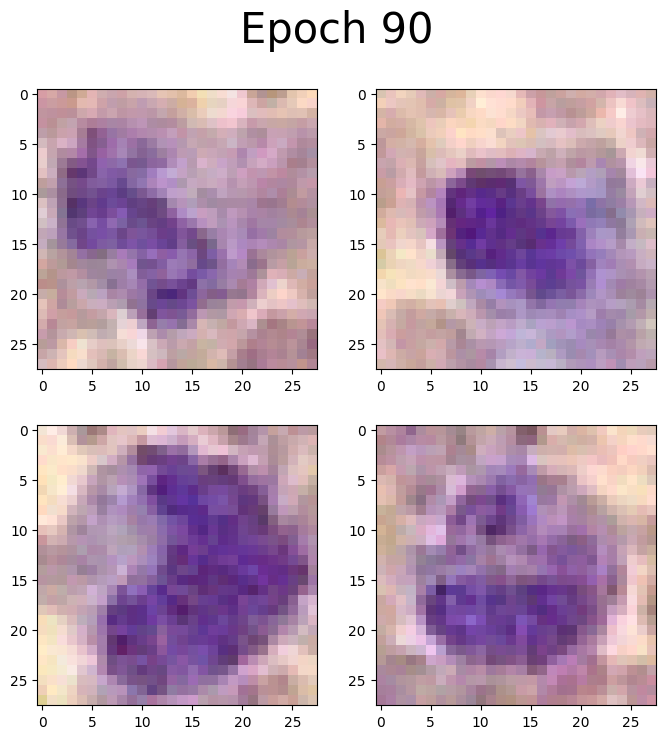

Epoch 90: Loss = 0.0561
Epoch 91: Loss = 0.0552
Epoch 92: Loss = 0.0556
Epoch 93: Loss = 0.0559
Epoch 94: Loss = 0.0563
Epoch 95: Loss = 0.0557
Epoch 96: Loss = 0.0550
Epoch 97: Loss = 0.0553
Epoch 98: Loss = 0.0549
Epoch 99: Loss = 0.0556


In [7]:
# Training
training_loop(ddpm, dataloader, n_epochs, optim=torch.optim.Adam(ddpm.parameters(), lr), device=device, display=True)

Generating new images


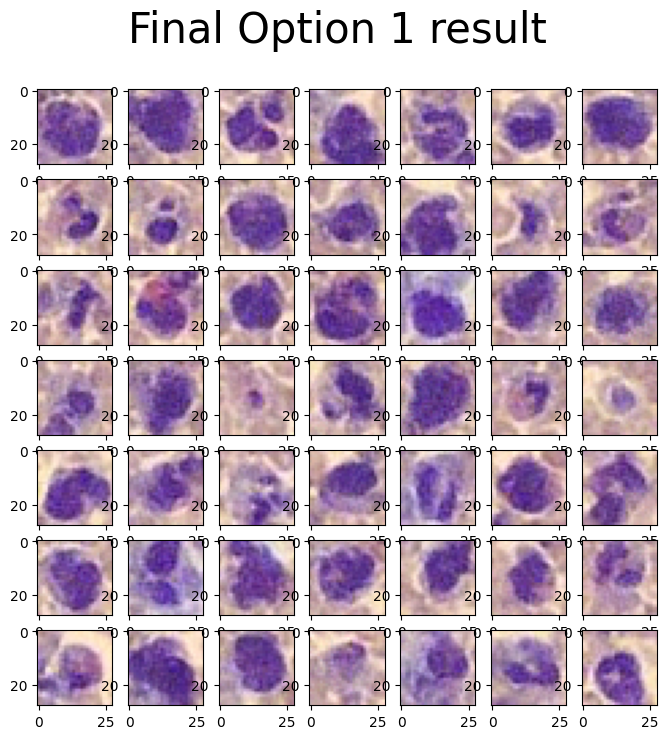

In [10]:
print("Generating new images")
generated = generate_new_images(
        ddpm,
        option = 2,
        n_samples= 49,# change the number of samples as needed
        device=device,
    )
show_images(generated, "Final Option 1 result")

# make grid of generated images
import torchvision.utils as vutils

grid = vutils.make_grid(generated, nrow=8, normalize=True, scale_each=True)

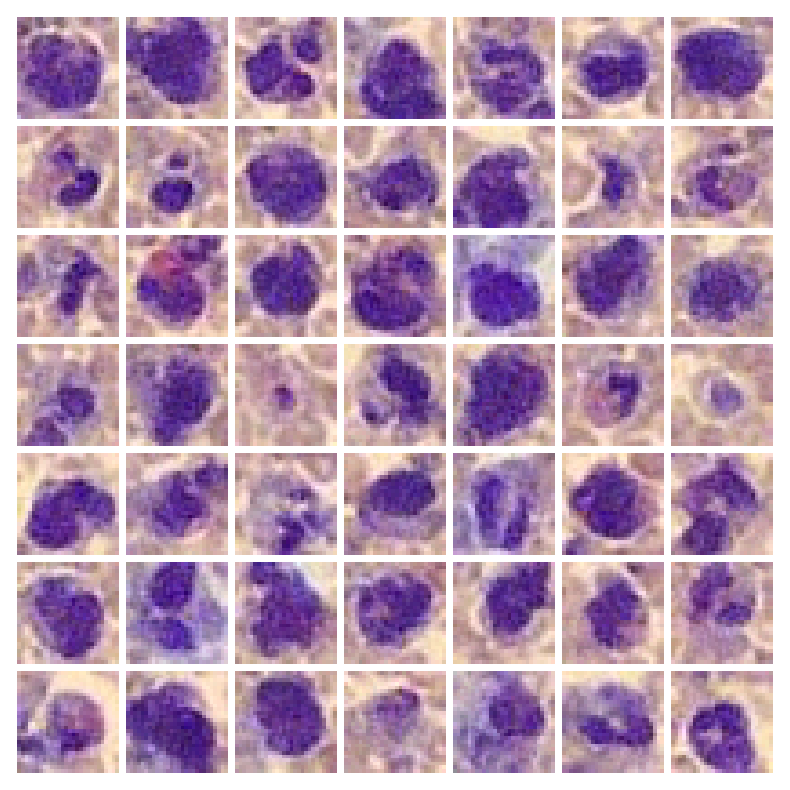

In [11]:
# display generated images
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to display generated images
def show_generated_images(images, device=device):

    
    # Create a grid with WHITE padding (pad_value=1.0)
    grid = vutils.make_grid(images, nrow=7, padding=2, normalize=True, pad_value=1.0)
    
    # Display the image
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Show exactly 25 newly generated images with white padding
show_generated_images(generated)

In [12]:
N_EVAL_SAMPLES = 1000

In [13]:
from torch.utils.data import DataLoader, RandomSampler, ConcatDataset
# **************************************
# Wrapper to use pytorch_fid's fid_score() with in-memory images
import pytorch_fid_wrapper as pfw

def get_fid(synthetic_samples):
    random_sampler = RandomSampler(
                dataloader, num_samples=N_EVAL_SAMPLES)

    eval_dataloader = DataLoader(
                dataset=dataset, batch_size=128, sampler=random_sampler)
    eval_tensor = torch.cat(
                [batch[0] for batch in eval_dataloader], dim=0)


    # 4. Compute Frechet Inception Distance (FID) between real and synthetic
    pfw.set_config(batch_size=10, dims=2048, device="cuda" if torch.cuda.is_available() else "cpu")
    # print(f"Real samples shape: {eval_tensor.shape}")
    # print(f"Fake samples shape: {synthetic_samples.shape}"
    fid = pfw.fid(fake_images=synthetic_samples,
                real_images=eval_tensor)
    print(f"FID:{fid}")
    
    return fid


In [14]:
import random

import numpy as np


EVAL_SEEDS = [100, 200, 300, 400, 500]


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)


fid_scores = []

for seed in EVAL_SEEDS:
    set_seed(seed)
    synthetic_samples = ddpm.generate_synthetic_samples(
        n_to_generate=N_EVAL_SAMPLES,
        batch_size=128,
        n_steps=n_steps
    )
    fid_score = get_fid(synthetic_samples)
    print(f"FID score for seed {seed}: {fid_score}")
    fid_scores.append(fid_score)
    
print(f"Average FID score: {np.mean(fid_scores)}")
print(f"Standard deviation of FID scores: {np.std(fid_scores)}")
print("Evaluation completed.")

Generating 1000 samples in 8 batches using 300 steps...
Using steps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 

c:\Users\josem\anaconda3\envs\cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\josem\anaconda3\envs\cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FID:295.70046835922204
FID score for seed 100: 295.70046835922204
Generating 1000 samples in 8 batches using 300 steps...
Using steps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,

KeyboardInterrupt: 